# Graded assignment 1 - text classification using Genetic Algorithms

In this assignmetn we'll make a binary text classifier using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. 

The assignment text contain 3 steps, so I divided the assignment in 3 sections:

1. Preprocessing of the text
2. Genetich Algorithm
3. Testing

**Preprocessing text**

First I upload all data, put them together and split them into training, validation and testing set. Then I preprocess the text using different methods like removing stop words, lemmaitzation etc.

Training set will be used to build vocabulary and IDF values. Validation set will be used when assigning fitness in Genetic Algorithm which I'll get into more. Testing set will be used at the end in validation part.

What we basically do here is to try to predict what class a text belongs to by making some calculations based on how many of which words the text containts. But when we do this calculation we don't want to consider all the words. That's because some words don't help with predictions. That's why we do preprocessing and turn all the reviews into equally sized vectors containing numerical values which can be proceeded by our neural network. How we do the preprocessing will be futher explained later.


I have built two classes for preprocessing stage. One is TextPreprocessor which processes contents with methods like removing stop words, lemmatization etc.

The other is TF-IDF vectorizer class which is used to build a Numpy array of TF-IDF vectors. Each document is turned into a TF-IDF vector. TF

**Genetic Algorithm**
Genetic algorithm  (often referred as GA) is an algorithm inspired by evolution theory. Here rather than species we have solutions to a problem. We call those solutions for Chromosomes. In this case Chromosomes are just weights for a neural network. We use methods like "cross-over" and "mutation" to make changes in those Chromosomes, and we try to pick the best Chromosome. In here the best Chromosome is 

The classifier I used is a simple neural network. I considered decision tree, but I'm not familiar with decision trees while I'm a bit familiar with neural network. Thus I decided to go with neural network. 

The neural net has only 2 hidden layers, 16 and 8 hidden nodes. I kept it simple because I had to take hardware limitations into account too. In the Genetic Algorithm every time we assign fitness we are going to predict the whole validation set for each classifier. So I didn't want to make it very slow.

**Testing**
Validation is simply using the optimizied weights to predict all reviews in the testing set to see how our GA performs. In the assignment text they suggested to use testing set for assigning fitness in GA and in validation part. But I thought that could make weights a bit biased. Thus other than training set I used two seperate sets: validation set and testing set. Validation set will be used when assigning fitness while optimizing weights in GA. Testing set will be used at the end.





## 1. Preprocessing

The preprocessing consists of two parts. Preproceesing the texts in the dataframe, and then converting the texts into vectors that can be used in classifier.

I have built twp seperate classes for each one. TextPreprocessor class and TF-IDF vectorizer.

I searched online about different vectorizartion methods in text classifying. I found TF-IDF vectorization contains more data than others, which could help in classifying. With TF-IDF vectors one can see which words are more "special" than others.

### 1.1 Uploading data

All the data is placed in four seperate folders. I found PlainTextCorpusReader from nlkt.corpus to be more effective in reading multiple text files. 




In [152]:
## Upload the text
import numpy as np
import pandas as pd
import nltk
import string
import re
import math
import random
from scipy import special
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I used for loop iteration to extract the info as array. Then I made a dataframe where I put all the samples together.

The data contains 3 columns (among index): reviews (the content of TXT files), labels (positive or negative, 1 or 0), and rates (extracted from file names).

I haven't used rate values anywhere in the assignment. I planned to use them but didn't use them. But still I didn't remove them so the code can be further developed.


In [153]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates all in arrays
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

In [154]:
whole_set = pd.DataFrame()

# Puttin all data into whole set
whole_set['review'] = reviews_train_pos + reviews_test_pos + reviews_train_neg + reviews_test_neg
whole_set['rate'] = rates_train_pos + rates_test_pos + rates_train_neg + rates_test_neg
whole_set['label'] = labels_train_pos + labels_test_pos + labels_train_neg + labels_test_neg

### 1.2 Splitting data

The original sample was like 50% was testing and 50% for training. That's too little for training and too big for testing. And there's no validation.

Thus I made the split into three: 
* 70 % on training, 
* 15 % on testing
* 15 % on validation.

Splitting the data into three sets where training set is significantly bigger is common in machine learning.

TF-IDF vectors will be based on training set. Thus we need training set to be in bigger size.

Validation set will be used in Genetic Algorithm when assigning fitness to classifiers.
Too big validation set could slow it the GA much.

Testing set will be used at the end to test how much the "trained classifier" performs.

Then I shuffle the data.

In [155]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()

# Dividing reviews into negative and positive to make sure data is always balanced
negatives = whole_set.loc[whole_set['label'] == 0]
positives = whole_set.loc[whole_set['label'] == 1]

# Splitting positive and negative reviews
train_set, valid_set, test_set = np.split(positives, [int(0.7*len(positives)), int(0.85*len(positives))])
tr_neg, vl_neg, ts_neg = np.split(negatives, [int(0.7*len(negatives)), int(0.85*len(negatives))])

# Appending negatives to positives
train_set = train_set.append(tr_neg)
valid_set = valid_set.append(vl_neg)
test_set = test_set.append(ts_neg)

# Shuffle and reset the index
train_set = train_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set

,review,rate,label
0,It's a soap-opera drawing upon an applied ethi...,7,1
1,I have to say this is better than most SyFy ou...,3,0
2,This movie is a waste of film stock. Do you be...,1,0
3,Clark Gable plays a con man who busts into the...,8,1
4,"I normally don't like romantic films, but I lo...",10,1
...,...,...,...
34995,"The idea of In the Name of the People is good,...",2,0
34996,The Outsiders is undoubtedly a classic Austral...,8,1
34997,"Admittedly, I tuned into this in the hopes of ...",3,0
34998,In the late 1940s there was a short film serie...,9,1


### 1.3 Data exploration

Here we explore how the data looks like. That is to figure out how to preprocess the data, what to eliminate etc.

In [156]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("\nMost common 20 counted by word count total: ", cnt.most_common(20))

# print("Least common 20 counted by appearance in nr of reviews: ", cnt2.most_common()[:-20])
# print("\nLeast common 20 counted by word count total: ", cnt.most_common()[:-20])



Most common 20 counted by appearance in nr of reviews:  [('the', 34512), ('a', 33657), ('and', 33527), ('of', 33109), ('to', 32761), ('is', 31043), ('in', 30224), ('this', 29017), ('that', 27272), ('it', 26552), ('I', 25151), ('for', 24184), ('with', 23784), ('but', 22444), ('was', 22333), ('The', 21788), ('as', 21391), ('on', 20873), ('/><br', 20460), ('have', 19648)]

Most common 20 counted by word count total:  [('the', 398431), ('a', 215543), ('and', 211791), ('of', 198887), ('to', 183609), ('is', 142852), ('in', 119064), ('I', 92383), ('that', 89328), ('this', 79871), ('it', 75658), ('/><br', 71081), ('was', 64813), ('as', 58564), ('with', 57992), ('for', 56780), ('The', 46966), ('but', 46488), ('on', 42896), ('movie', 42730)]


As seen there are a lot of stop words. There are HTML tags in the set too. The stop words and HTML tags will be removed in with TextPreprocessor class.

Vocabulary here means all the words used in the training set. The vocabulary will be based on training set.

Text(0, 0.5, '% of documents')

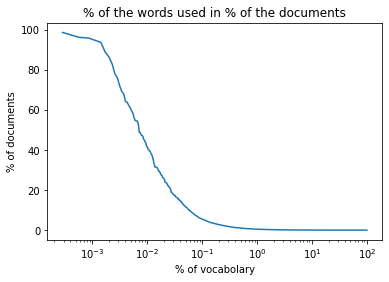

In [157]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = len(train_set)

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

The graph above shows how much % of the vocabulary is used by how much % of the documents.

We see that only a tiny fraction of the vocubulary are used in most of the documents. 
Most of the words in vocabulary are rare words, also they're used only in a small fraction of the documents.

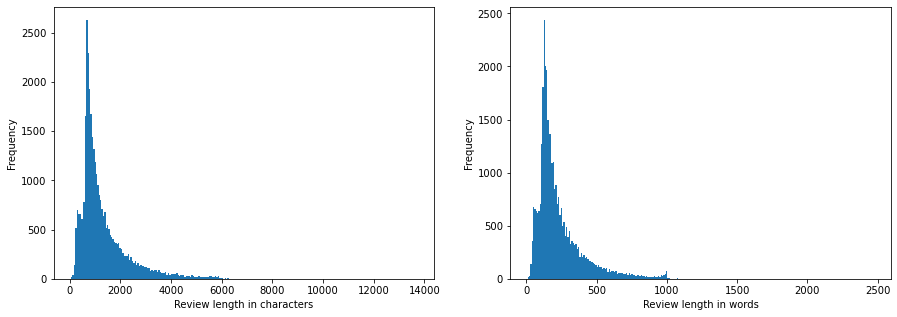

In [158]:
# Length distribution of the reviews
train_set['rev_lens_raw'] = train_set['review'].str.len()
train_set['rev_lens_words'] = train_set['review'].str.split().apply(len)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(train_set['rev_lens_raw'], bins='auto')
ax[0].set_xlabel("Review length in characters")
ax[0].set_ylabel("Frequency")
ax[1].hist(train_set['rev_lens_words'], bins='auto')
ax[1].set_xlabel("Review length in words")
ax[1].set_ylabel("Frequency")

plt.show()

The histograms above shows distribution of frequency and review length. The longest reviews are 1000 words which is not very unusual. 

We want to see if short reviews contain garbage, and see they look like normal movie reviews.

In [159]:
# Shortest reviews
train_set.nsmallest(10, 'rev_lens_words')['review'].values

array(['I hope this group of film-makers never re-unites.',
       'Brilliant and moving performances by Tom Courtenay and Peter Finch.',
       'This movie is terrible but it has some good effects.',
       "I wouldn't rent this one even on dollar rental night.",
       "You'd better choose Paul Verhoeven's even if you have watched it.",
       'Adrian Pasdar is excellent is this film. He makes a fascinating woman.',
       'Ming The Merciless does a little Bardwork and a movie most foul!',
       'Long, boring, blasphemous. Never have I been so glad to see ending credits roll.',
       'This is a great movie. Too bad it is not available on home video.',
       'Comment this movie is impossible. Is terrible, very improbable, bad interpretation e direction. Not look!!!!!'],
      dtype=object)

In [160]:
# Drop reviews that are very long
#train_set = train_set.loc[train_set['rev_lens_word'] < 1800]
#train_set.reset_index(inplace=True, drop=True)


### 1.4 Preprocessing and vectorization

Prerocessing and vectorization serves same goal. What we want to do is to buid

What we basically want to do here is to try to predict what class a text belongs to by making some calculations based on how many of which words in the vocabulary that particular text contains. 

So we want to build a vocabulary first, also a list of words. But we don't want to include absolutely all words used in the training set to be included in the vocabulary. Thus we make some preprocessing, some filtering etc. and that's where TextPreprocessor comes in.

E.g. stopwords like "the", "a", "and" etc. don't say anything about whether the review is positive or negative. Thus in the preprocessing stage we eliminate them. We eliminate numbers and other words too that don't give meaning.

Very common words, words that are used in almost all reviews, don't say much about if the review is negative or positive. So we eliminate most common words too. But very rare words also don't say much about 


#### 1.4.1 TextPreprocessor class

Most of the functions are in this class are taken from a code posted on Canvas. I just put hem into a class, made some changes and built some additional functions.

Preprocessing is done with a function in TextProcessor class named def `preprocess_imdb_reviews()` which uses other functions in the class. It processes all the text in a dataframe under column "review" and returns a dataframe with additional column named "processed" where all processed text are saved. I keep both of them to be able to repeat code and to make a comparison later.

The functions are applied by using .apply() function of the dataframe, which apply a function to each row in a chosen column.

As mentioned we don't want to include all words used in the training set to be included in the vocabulary. Thus we make some changes. Here is how we process the text:
1. We make all lower cases. Some people use upper case to highlight their words, and first letter of words are in upper case after periods. All all those words mean the same thing, so we don't want to discriminate between those. The only problem here is that movie names and person names would be processed just like some words. E.g. the movie "Cars" would be interpreted as noun in plural form cars, and eventually be lemmatized into car or removed. But it's very difficult to write a code to determine what is movie / person name or not, and they don't say much about whether a movie review is positive or negative. Thus for now we just ignore this problem. Lower casing all words also makes other processing steps easier.
2. We remove HTML tags. They are not words with meaning, just some clutter to be removed.
5. We remove URLs. They are not words with meaning, so just remove them.
3. We convert emoticons into text. We do this before removing numbers or anything else as emoticons may contain numbers too. We don't want to remove them as they may contain useful information about the review.
4. We remove numbers. They can be dates, ages etc. which don't give much relevant info about the review.
6. We expand contractions. Alos "don't" means same as "do not". So we don't want to distinguish between those. Expanding contractions also will make removing stop words easier. It's important to do it early as it will generate new stop words.
7. We remove emojis
8. We remove punctuations, like dots and slashes. In computers "something" and "something," are perceived as two different words, we don't want that.
9. We lemmatize words. Lemmatizing means converting words to base forms.E.g. "boring" and "bored" are same words, "child" and "children" are actually same word. We want the computer to perceive them as same words too. Words with same base should be considered as same word.
10. We remove the stop words. Words like "the", "a", "and" may be used in all reviews and don't give any information about review. So we just remove them.
11. Curbing. We remove the words that exists in more than 85 % of the documents. They are some common words that don't give much context. And we remove the words that exists in less than 0.05 % of the documents. Rare words are words like special movie names, actor names, weirdo words, misspesllings etc. Words that are used only here and there or only in one review can't be used in calculating which class a reviews belongs to. The rates 0.85 and 0.0005 are paramaters to the function. I experimented with different values, I don't want to end up with vocabulary that's too little, but nor too big. Most of the words in vocabulary are rare words that are used in tiny fraction of the set. Thus the bottom curb is just 0.0005. Too little vocabulary give too little information. Too big vocabulary is too heavy for the neural network, and may contain a lot of words that give little information. A vocabulary of 10k-20k is enough. After experiemting with different values I did choose 0.85 and 0.0005 as curbing values.
12. At the end I found some garbage words still existing in the set. I made an array of those and removed those from all the reviews. The array is: ["□", "▢", "■", "\x96", "st", "nd", "rd", "th"]. \x96 is just some triangle. st, nd, rd and th are remainders of numerical values like 1st, 2dn, 3rd, 4th etc. which is meaningless.








In [161]:
# I think to put this into own .PY file and import from there
class TextPreprocessor():
    def __init__(self):
        import nltk
        import re
        import string
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        from nltk.stem.wordnet import WordNetLemmatizer 
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }
        
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile('<.*?>')

    def lower_case(self, text):
        return str.lower(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        return " ".join([word for word in text.split() if word not in self.stop_words])
    
    def remove_words(self, text, freq_words):
        return " ".join([word for word in text.split() if word not in freq_words])
    
    def remove_emoji(self, text):
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        import re
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return " ".join(tokens)
    
    def expand_contractions(self, text):
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" wasn't ", " was not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_numbers(self, text):
        text = re.sub(r'[0-9]', '', text)
        return text
    
    def remove_html_tags(self, text):
        return self.html_pattern.sub(r'', text)
    
    def remove_urls(self, text):
        return self.url_pattern.sub(r'', text)
    
    def process_text_vectorized(self, text):
        text = self.lower_case(text)
        text = self.remove_html_tags(text)
        text = self.remove_numbers(text)
        text = self.remove_urls(text)
        text = self.expand_contractions(text)
        text = self.remove_emoji(text)
        text = self.remove_punctuation(text)
        text = self.lemmatization(text)
        text = self.remove_stopwords(text)
        return text
    
    def preprocess_2(self, corpus, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        
        vecpreprop = np.vectorize(self.process_text_vectorized)
        
        arr1 = vecpreprop(corpus)
        
        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in corpus:
            # Counting the words
            for word in text.split():
                cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
        freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        rem_freq_words = np.vectorize(self.remove_words)
        arr2 = rem_freq_words(arr1, freq_words)

        # Removing rarest words
        rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
        
        rem_rare_words = np.vectorize(self.remove_words)
        arr3 = rem_rare_words(arr2, rare_words)

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(corpus) * max_df
        curb_min_amount = len(corpus) * min_df

        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        print(len(cnt2))
        print(len(curb_words))
        rem_curb_words = np.vectorize(self.remove_words)
        arr4 = rem_curb_words(arr3, curb_words)
        
        return arr4

        
        
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_html_tags(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.convert_emoticons(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_numbers(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))
        df['processed'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_stopwords(text))


        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in df['processed'].values:
            # Counting the words
#             for word in text.split():
#                 cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
#         freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, freq_words))

#         # Removing rarest words
#         rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rare_words))

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df
        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, curb_words))
        
        # Other words to remove
        rem_words = ["\x96", "st", "nd", "rd", "th"]
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rem_words))

        return df, cnt2


#### 1.4.2 TF IDF Vectorizer class

TF-IDF stands for Term Frequency - Ineverse Document Frequency. TF is a number that shows frequency of term in the document, in this case in a particular reveiw. IDF is calculated by: $log(\frac{n}{1+DF})$ where N is number of documents in the Corpus, (here we use trainin set as corpus) and DF is document frequency, also number of documents that term appears in. If DF is high, the that must be a more common term, and TF of that term in the document has less weight.

TF-IDF values are ${TF \times IDF}$ or ${TF \times log(\frac{n}{1 + DF})}$ It takes into account both how much a term appears, and how unique is that term for that review.

There are different wasy to calculate TF-IDF values. I used this to avoud division by zero, as we add 1 in the divisor. In some websites they use 1 + n in the dividend to avoid negative values. But since we have removed all terms that apperas in more than 85 % of the documents, it's no term in the vocab appears in all documetns. So negative values of TF-IDF is not possible in this case.



When initializing the TfIdfVectorizer class I pass in dataframe (the training set) as argument. Then using two functions (prepare_idfs and prepare_vocab) it builds two dictionaries and saves them.

`self._vocab` is a dictionary where the keys are vocabulary taken from processed reviews in the training set. Also it's all the words used in the processed reviews in the training set. Values are used to determine which index TF-IDF values should be saved on. Each value in the `self._vocab` dictionary determines which index the TF-IDF value of a term in the review sohuld be be saved on.

`self._idfs` is a dictionary that has same keys as `self._vocab`. But it will contain the IDF values of each term, where IDF's are based on the training set, also based on who many times that term appears in the training set.


When we vectorize any text to put it into classification, we first preprocess it using functions in "TextPreprocessor", then we vectorize it using  `tf_idf_vectorize_all()`. That function accepts dataframe as argument. It will use .apply of the Pandas Dataframe and run `tf_idf_vectorize()` for each row in the 'processed'. Then we convert it to Numpy Array and return it.

`tf_idf_vectorize_all()` will return a Numpy array that has an array for each review, where size of each array is equal to size of `self._vocab` or vocabulary, with TF-IDF values that saved in the indexes that represent the words in the vocab (what index for what word is determined by using `self._vocab` dictionary).



Here's illustration with a small example:

For simple illustration let's say our corpus is very small and vocabulary has just 3 words. Then the `self._vocab` would be like:
{"hello": 0, "world": 1, "python": 2}.

`self._idfs` would be something similar, just it will contain IDF values. E.g. based on their frequencies, document size etc. it could be something like:

{"hello": 0, "world": 0, "python": 0.405}.

Here we assume the set has 8 documents. "hello" and "world" appears in 2 documents and "python" appears in one. So their values will be as shown above.

E.g. if the text is "hello hello world in python". We will ignore the word 'in' since it's not in the `self._vocab` dictionary.

We see the word "hello" exists in the `self._vocab` and has value '0 and its IDF value is 0 in `self._idfs`. It appears two times.
So we multiply 2 by 0, and save the value in index 0. The word "world" has the value '1' in the `self._vocab` dictionary, 0 in `self._idfs` dictionary, appears once in the document. So we multiply 1 by 0, and save the result in index 1. We repeat the same process for python. Then we return a Numpy array that looks like: [0, 0, 0.405]

The `self._idfs` and `self._vocab` is used in the code to make the vector generation more efficient, as we don't have to generate vocabs and IDF values each time.



In [162]:
# TF-IDF VECTORIZER CLASS
import math
from collections import Counter
import numpy as np
from nltk import FreqDist

class TfIdfVectorizer:
    def __init__(self, df):
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        self._idfs = idfs
    
    @property
    def vocab(self):
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        # Prepare the vocab
        self.vocab = set(" ".join(df['processed'].values).split())
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["processed"].values:
            for word in set(text.split()):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = math.log((1+size) / (1 + c))
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        freq_dist = FreqDist(text.split())
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        vectors = np.array(df['processed'].apply(lambda text: self.tf_idf_vectorize(text)).values.tolist())
        return vectors
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        vector = np.array(df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels)).values.tolist())
        return vector


    

#### 1.4.3 Preprocessing

Here we preprocess training set, testing set and validation set

In [170]:
#Using the preprocessor
preprocessor = TextPreprocessor()
train_set_processed, cnt1 = preprocessor.preprocess_imdb_reviews(train_set, 0.85, 0.0005)
test_set_processed, cnt2 = preprocessor.preprocess_imdb_reviews(test_set, 0.85, 0.0005)
valid_set_processed, cnt3 = preprocessor.preprocess_imdb_reviews(valid_set, 0.85, 0.0005)

train_set_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,rate,label,rev_lens_raw,rev_lens_words,processed
0,It's a soap-opera drawing upon an applied ethi...,7,1,1279,235,draw upon apply ethic idea movie human suffer ...
1,I have to say this is better than most SyFy ou...,3,0,700,132,say good say muchthe plot someone buy game mak...
2,This movie is a waste of film stock. Do you be...,1,0,1758,327,movie waste film stock believe map plan milita...
3,Clark Gable plays a con man who busts into the...,8,1,1113,188,clark gable play con man bust life hardboiled ...
4,"I normally don't like romantic films, but I lo...",10,1,1313,234,normally like romantic film love film much sto...
...,...,...,...,...,...,...
34995,"The idea of In the Name of the People is good,...",2,0,596,113,idea name people good murderer want daughter e...
34996,The Outsiders is undoubtedly a classic Austral...,8,1,646,110,outsider undoubtedly classic australian tv ser...
34997,"Admittedly, I tuned into this in the hopes of ...",3,0,2147,365,admittedly tune hop see beefcake shot jam brol...
34998,In the late 1940s there was a short film serie...,9,1,4848,788,late short film series entitle flicker flashba...


#### 1.4.4 Checking preprocessed data

Here we explore the preprocessed data again.

In [171]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set_processed["processed"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

Most common 20 counted by appearance in nr of reviews:  [('movie', 22411), ('film', 20510), ('one', 19663), ('make', 17703), ('like', 16998), ('see', 16925), ('good', 16352), ('get', 14864), ('time', 13671), ('would', 13272), ('watch', 12599), ('go', 12362), ('even', 11706), ('think', 11388), ('character', 11383), ('story', 10745), ('really', 10538), ('bad', 10468), ('much', 9697), ('say', 9418), ('look', 9410), ('well', 9400), ('could', 9380), ('great', 9321), ('know', 9248), ('act', 9211), ('give', 9140), ('scene', 9043), ('end', 9029), ('also', 8730), ('take', 8725), ('way', 8668), ('come', 8666), ('people', 8580), ('first', 8553), ('thing', 8280), ('show', 8202), ('find', 8153), ('play', 7844), ('love', 7718), ('seem', 7207), ('want', 7086), ('many', 7018), ('plot', 7003), ('work', 6965), ('never', 6943), ('actor', 6839), ('try', 6680), ('two', 6660), ('best', 6658), ('little', 6628), ('year', 6609), ('ever', 6566), ('still', 6063), ('life', 5941), ('something', 5579), ('feel', 548

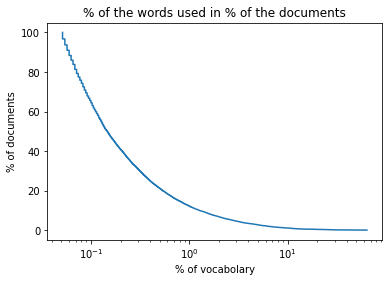

In [172]:
#print("Most common 50 counted by appearance in nr of reviews: ", cnt1.most_common(50))

vocab_size = len(cnt2)
sample_size = len(train_set)

x = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
y = [c/vocab_size * 100 for c in range(1, vocab_size+1)]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")
plt.show()

From the graph above we see that after preprocessing the distribution of vocabulary in the documents are more smooth.

Below we see some random samples to check if the data is garbage or not. And we see it looks OK.

In [173]:
train_set_processed.sample(10)

,review,rate,label,rev_lens_raw,rev_lens_words,processed
11423,"The funniest show ever on TV, albeit the humor...",10,1,3791,661,funny show ever tv albeit humor everyone reali...
2927,Every now and again you hear radio djs invitin...,1,0,1479,251,every hear radio dj invite listener nominate m...
7342,I love the music of the Clash and I love the m...,3,0,1642,302,love music clash love music joe go movie hop l...
24544,"""The Planet"" is an astounding piece of film ma...",7,1,1842,322,planet astound piece film make mere £ producti...
20923,I saw this movie in 1959 when I was 11 years o...,10,1,1196,215,saw movie year old drivein theater back think ...
34315,I would not consider myself as one of Leonard ...,2,0,1990,344,would consider one leonard cohen great fan how...
21382,I knew full well when I rented this DVD that i...,1,0,1037,185,know full well rent dvd could well one bad mov...
32484,I had heard this film was a study of a landsca...,10,1,2891,484,hear film study landscape photographer art pre...
10381,I would give this a zero if they had that rati...,1,0,789,153,would give zero rat fun fun grow tire movie te...
25122,A patchwork about 911. The 11 stories from 11 ...,9,1,1008,160,story director country sometimes sometimes bor...


#### 1.4.5 Vectorizing data sets using TF-IDF vectors

Here we instantiate TfIdfVector useing processed train set. We save the idfs and vocab in a variable for easier reference.

Then we generate Numpy arrays. X_train contains vectors representing reviews, Y_train contains labels in a numpy array.



In [174]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab

In [ ]:
# Vectorizing train set and test set
X_train = vectorizer.tf_idf_vectorize_all(train_set_processed)

X_test = vectorizer.tf_idf_vectorize_all(test_set_processed)

X_valid = vectorizer.tf_idf_vectorize_all(valid_set_processed)

Y_train = train_set_processed['label'].to_numpy()

Y_test = test_set_processed['label'].to_numpy()

Y_valid = valid_set_processed['label'].to_numpy()

Here we check if labels fit. We print the vocab to see which words are included in the vocab. While it contains a couple of weird words, most of them looks OK. We see the length of vocab is ca 12k which is big enough.

In [188]:
# Check if labels fit
index = random.randint(0, len(train_set))
print(Y_train[index])
print(train_set.loc[index, 'label'])

print(len(vocab))
vocab

1
1
12050


{'vomit': 0,
 'hippie': 1,
 'min': 2,
 'skateboard': 3,
 'anita': 4,
 'consent': 5,
 'biological': 6,
 'fake': 7,
 'gielgud': 8,
 'booth': 9,
 'spacey': 10,
 'versatile': 11,
 'assistance': 12,
 'heart': 13,
 'subtly': 14,
 'illustrate': 15,
 'dir': 16,
 'journey': 17,
 'infinitely': 18,
 'himthe': 19,
 'newman': 20,
 'pause': 21,
 'custer': 22,
 'establishment': 23,
 'yacht': 24,
 'inherit': 25,
 'doom': 26,
 'lowbrow': 27,
 'reservoir': 28,
 'fonda': 29,
 'loosen': 30,
 'suspension': 31,
 'korean': 32,
 'previous': 33,
 'great': 34,
 'thug': 35,
 'chunk': 36,
 'intestine': 37,
 'evade': 38,
 'snake': 39,
 'burr': 40,
 'quite': 41,
 'poke': 42,
 'undemanding': 43,
 'template': 44,
 'since': 45,
 'plea': 46,
 'attitude': 47,
 'radha': 48,
 'stomach': 49,
 'slop': 50,
 'maniac': 51,
 'due': 52,
 'detroit': 53,
 'ogle': 54,
 'margin': 55,
 'ambitious': 56,
 'impale': 57,
 'town': 58,
 'imo': 59,
 'stereotypical': 60,
 'magic': 61,
 'moviegoing': 62,
 'boost': 63,
 'syrupy': 64,
 'barrymo

## 2. Set up genetic algorithm

Genetic Algorithm is an algorithm that's inspired by evolution theory. Here we have a list of solutions that can be anything that keeps some data in some form of data-structures. They "mutate" and "reproduce" and new generations are produced. We choose the best chromosomes and eliminate bad ones. The goal is to come up with the best solution after some generations.

I built 3 classes to apply the genetic algorithm.
1. The classifier: It's a simple neural network. It takes vectors as input and classifies it, and calculates Cross Entropy Loss and accuracy.
2. The Chromosome: This is a class that essentially just keeps the weights and makes operations on the weights. In GA we are trying to optimize the weights. So it has some functions like mutation, crossover and assigning fitness.
3. GAEngine (Genetic Algorithm Engine): This class makes operations on the chromosomes at a higher lever. It has functions like choosing chromosomes to mutate, to do crossover, choosing what chromosomes to keep etc. and it has a function that runs the routine of the genetic algorithm training.

The structure where we use two seperate classes, GAEngine and Chromosome, is inspired from an earlier base code on GA assignment. On some guides online they use that structure too. It's very logical, convenient and easy to understand. Chromosome objects represents the "species" and GAEngine represents the "nature" in evolution theory.

While the GA training routine was put outside the GAEngine in the earlier GA assignment, I put it inside in a function here. That is to make the code more clean.

I could use both classifier and Chromosome as same class, since both keeps weights. But classifier keeps vocab and idfs. I didn't want to keep same data multiple places. Their functions are distinct, classifier is a classifier, but Chromosome just keeps and opreates on weights. So keeping them as distinct classes makes more sense and gives more clean structure.


### 2.1 Classifier
In the assignment text they mention using decision tree. I tried to build one, but I have not much experience with decision trees. There are other classifiers too. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

Too simple architecture fails to make prediction. I tried with simple architecture and it was almost untrainable. Too complicated architecture (too many nodes, too much hidden layers) causes overfitting and it's very slow in training and prediction. After experimenting with different models, the model I decided is this:

Input is as long as length of the vocab, which is 1250.

Then a hidden layer of 16 nodes, using ReLU as activation function.
Then a hidden layer of 8 nodes, using ReLU as activation function.
Then using one more hidden layer of 2 nodes. No special activation function is used, it's just linear.
Then at the end I use "SoftMax" to get predictions as output.

Number of layers can't be set dynamically, but number of hidden nodes can be set dynamically while instantiating the classifier.

The classifier returns both "Cross Entropy Loss" and "accuracy".


In [177]:
class Classifier:
    def __init__(self, idfs, vocab):
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
        self.ws_3 = 0
        self.np_predictor = np.vectorize(lambda vec: self.predict(vec))
        self.hn_1 = 0
        self.hn_2 = 0
        self.in_vector = 0

    # Initializing weights
    def init_weights(self):
        self.ws_1 = np.random.rand(self.in_vector, self.hn_1) - 0.5
        self.ws_2 = np.random.rand(self.hn_1, self.hn_2) - 0.5
        self.ws_3 = np.random.rand(self.hn_2, 2) - 0.5
        return self.ws_1, self.ws_2, self.ws_3
        
    def set_weights(self, ws_1, ws_2, ws_3):
        self.ws_1 = ws_1
        self.ws_2 = ws_2
        self.ws_3 = ws_3
    
    def set_hidden_nodes(self, in_vector, hn_1, hn_2):
        self.hn_1 = hn_1
        self.hn_2 = hn_2
        self.in_vector = in_vector

    def relu(self, x):
        return (x > 0) * x
    
    def relu_grad(self, x):
        return x > 0
    
    def sigmoid(self, x):
        from scipy import special
        return special.expit(x)
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    
    def softmax(self, x):
        import numpy as np
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        
    def train_with_SGD(self, epochs, lr, x, y):
        error_list = list()
        mse_list = list()
        
        for n in range(epochs):
            for i in range(x.shape[0]):
                l_in = x[i:i+1]
                l_o, l_4, l_3, l_2, l_1, s_1 = self.predict(l_in, True)           
                
                delta_2 = l_2 - y[i]
                delta_1 = delta_2.dot(self.ws_2.T) * self.relu_grad(l_1)
                
                self.ws_2 -= lr * (l_1.T.reshape(self.hn_1,1).dot(delta_2))
                self.ws_1 -= lr * (l_in.T.reshape(x.shape[1],1).dot(delta_1))

                error = delta_2**2
                    
                error_list.append(error[0][0])
            
            mse_list.append(sum(error_list) / x.shape[0])
            error_list = list()
        
        cel, output, acc = self.predict_whole_set(x, y)
        
        return mse_list, cel, output, acc
                

    def cross_entropy(self, p, y):
        import numpy as np
        return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
    
    def predict(self, x, get_all=False):
        #forward pass/prediction
        layer_1 = self.relu(x.dot(self.ws_1))
        layer_2 = self.relu(layer_1.dot(self.ws_2))
        layer_3 = layer_2.dot(self.ws_3)
        layer_out = self.softmax(layer_3)
        if get_all:
            return layer_out, layer_3, layer_2, layer_1
        else:
            return layer_out
    
    def get_accuracy(self, y, p):
        acc = np.sum((y == np.argmax(p, axis=1))) / len(y)
        return acc
    
    
    
    def predict_whole_set(self, x, y, get_acc = True):
        output = np.apply_along_axis(self.predict, 1, x)
        cel = self.cross_entropy(output, y)
        if get_acc:
            acc = self.get_accuracy(y, output)
        if get_acc:
            acc = self.get_accuracy(y, output)
            return cel, output, acc
        else:
            return cel, output
    

        

Here we initialize and test our classifier to see how it predicts, if it works as expected or not.

In [189]:
# Initialize classifier
classifier = Classifier(idfs, vocab)

In [201]:
classifier.set_hidden_nodes(len(vocab), 16, 8)
classifier.init_weights()
cel_pre, output, acc_pre = classifier.predict_whole_set(X_valid, Y_valid)
print(cel_pre)
print(acc_pre)

print(output)
print(classifier.ws_1, classifier.ws_2, classifier.ws_3)

5.072011638796448
0.4997333333333333
[[9.99999889e-01 1.11383809e-07]
 [9.99999319e-01 6.81348389e-07]
 [9.68211864e-01 3.17881359e-02]
 ...
 [1.00000000e+00 1.11331204e-10]
 [9.96560720e-01 3.43927973e-03]
 [9.80281584e-01 1.97184162e-02]]
[[ 0.26542981  0.3311624  -0.47937628 ...  0.26767305 -0.44613391
   0.02103476]
 [-0.22424768 -0.22932442  0.09071726 ... -0.46091949 -0.25229599
   0.02260476]
 [-0.26262228  0.33867296 -0.30985399 ...  0.31160553  0.20990047
  -0.07684057]
 ...
 [-0.00915567 -0.02611491 -0.41027426 ... -0.43388695 -0.16385741
  -0.34452612]
 [-0.21153285  0.3718312  -0.36969389 ... -0.26912316  0.39565801
   0.34493465]
 [-0.16418904  0.40560293 -0.3709111  ... -0.29967806  0.14333594
   0.1420141 ]] [[-0.44987885  0.05377849  0.46163044  0.43166965  0.45261441  0.21427695
   0.24883992 -0.11608683]
 [-0.45167024 -0.14885657 -0.3353464   0.32729204  0.2174291   0.23605159
  -0.2059786  -0.22101227]
 [-0.4054087  -0.27331523 -0.28265061 -0.26086687  0.04328779 -0.

### 2.2 Chromosome
This is the Chromosome. Chromosome keeps the weights and has some methods for mutation, cross.over and fitness calculation

I have written own operator functions like`__eq__`. The comparisons will be made based on value of `self.fitness`. In the GAEngine I do compare the fitness values and sort the lists, so rather than calling lambda each time I cal max() or sorte(), I did implement those functions to make the code more clean and robust.

The Chromosome has three essential functions:
1. Assign fitness. This uses the classifier class above. It is based on accuracy after predicting the data on validation set. The goal is to increase the accuracy as much as possible.
2. Cross over: it accepts another chromosome as parameter. New weights are produced from calculations which made based on weight values of both chromosomes (self and other). Then a new chromosome is iniitalized and returned. It's as parents give offspring to a child where childs genes are combination of parent's genes. But in this algorithm the Chromosomes has no genders, so anyone can make offspring from anyone.
3. Mutation: here we make som random changes on the weights of the Chromosome.



In [95]:
class Chromosome:
    # x_pos and y_pos are the features of our chromosome
    def __init__(self, ws_1, ws_2, ws_3):
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
        self._ws_3 = ws_3
    
    # Getters and setters
    @property
    def ws_1(self):
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        self._ws_1 = value
    
    @property
    def ws_2(self):
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        self._ws_2 = value
    
    @property
    def ws_3(self):
        return self._ws_3
    
    @ws_3.setter
    def ws_3(self, value):
        self._ws_3 = value
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        self._fitness = value
    
    def __lt__(self, other):
        return self.fitness < other.fitness

    def __le__(self, other):
        return self.fitness <= other.fitness
    
    def __eq__(self, other):
        return self.fitness == other.fitness
    
    def __ne__(self, other):
        return self.fitness != other.fitness
    
    def __ge__(self, other):
        return self.fitness >= other.fitness
    
    def __gt__(self, other):
        return self.fitness > other.fitness
    
    def assign_fitness(self, classifier, x, y):
        import math
        classifier.set_weights(self.ws_1, self.ws_2, self.ws_3)
        loss, _, acc = classifier.predict_whole_set(x, y, True)
        self.fitness = acc #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        r = 2
        
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        min_mat_3 = np.minimum(self.ws_3, other.ws_3)
        max_mat_3 = np.maximum(self.ws_3, other.ws_3)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r)
        ws_3 = np.random.uniform(min_mat_3-r, max_mat_3+r) 
        
        offspring = Chromosome(ws_1, ws_2, ws_3)
        return offspring

    # mutate the individual
    def mutate(self):
        np.random.shuffle(self.ws_1)
        self.ws_1 = self.ws_1 + np.random.uniform(-5, 5, size=self.ws_1.shape)
        np.random.shuffle(self.ws_2)
        self.ws_2 = self.ws_2 + np.random.uniform(-5, 5, size=self.ws_2.shape)
        np.random.shuffle(self.ws_3)
        self.ws_3 = self.ws_3 + np.random.uniform(-5, 5, size=self.ws_3.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

Here I have divided the chromosome in two groups: elite and population.
Elite contains the population with highest fitness. This is to make sure if we find a very fit chromosome we don't lose it again because of cross overs or mutations.

And we make the mutations first. We make mutations on the least fit chromosomes. We don't want to mutate highest fit chromosomes. How many to mutate is also passed as a parameter. After mutations we determine the mutated chromosomes new fitness values and update elite list again.

In the cross-over I use something similar to roulette wheel. How much of the crossover will be from elite will be passed as a parameter. 
Based on that value, I produce M number of offsprings only from the elites (chosen randomly). Elites are the list of most fit chromosomes. How many to keep in elites is also passed as a parmater to training function.

And I produce N number of offsprings from the chromosomes randomly chosen from population. But here the random choice is weighted one, also it's higher probabilty to choose chromosomes with higher fitness values. After all the cross overs the old population is thrown out and new generation is produced from the offsprings. The number of the offsprings is equal to the number of the population to avoid decrease or increase in the population. Since we keep the most fit ones in the elite list, we don't lose winners by replacing the old generation with the new geneartion.

After the cross-overs it determines the fitness values of the new population and update the elite list again.





In [96]:
class GAEngine:
    def __init__(self, classifier):
        self._population = []
        self._generations = 0
        self._classifier = classifier
        self.elite = []
        self.nr_of_elites = 0

    def make_initial_population(self, population_size):       
        for i in range(population_size):
            ws_1, ws_2, ws_3 = self.classifier.init_weights()
            self.population.append(Chromosome(ws_1, ws_2, ws_3))

        
    @property
    def generations(self):
        return self._generations
    
    @generations.setter
    def generations(self, g):
        self._generations = g
    
    @property
    def population(self):
        return self._population
    
    @population.setter
    def population(self, p):
        self._population = p
    
    @property
    def classifier(self):
        return self._classifier
    
    @classifier.setter
    def classifier(self, cl):
        self._classifier = cl
    
    # selection code goes here...
    def do_crossover(self, elite_crossover_rate):
        import random
        population_size = len(self.population)
        
                
        # Here we combine elitism selection with roulette wheel
        # We carry some of the most fit over to the next generation.
        # We do cross over with both the elite and other population
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        no_of_elite_crossovers = int(elite_crossover_rate * population_size)
        
        other_offspring = population_size - no_of_elite_crossovers

        new_generation = list()
        
        # Offsprings from the elite
        for i in range(no_of_elite_crossovers):
            parent1, parent2 = random.choices(self.elite, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # Weighted random choice
        fitness_values = [x.fitness for x in self.population]
        
        # Offsprings from other population
        for i in range(other_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # The population is the new generation
        self.population = new_generation
        return
    
    
    def do_mutation(self, no_of_mutation, x, y):
        for i in range(no_of_mutation):
            self.population[-i-1].mutate()
            self.population[-i-1].assign_fitness(self.classifier, x, y)
    
    
    # fitness calculation goes here...
    def assign_fitness(self, x, y):
        for ch in self.population:
            ch.assign_fitness(self.classifier, x, y)
        self.population = sorted(self.population, reverse=True)
        self.update_elite()
        return
    
    def get_population(self):
        return self.population
    
    def update_elite(self):
        if len(self.elite) == 0:
            self.elite = self.population[-self.nr_of_elites:]
            self.elite = sorted(self.elite, reverse=True)
            return
        i = 0
        j = 0
        while i < self.nr_of_elites and j < len(self.population):
            if self.elite[i] < self.population[j]:
                self.elite[i] = self.population[j]
                i += 1
                j += 1
            else:
                i += 1
        
        self.elite = sorted(self.elite, reverse=True)

    
    def get_best_chromosome(self):
        return max(self.elite)
    
    
    
    # TRAINING ROUTINE
    def training_routine(self, init_population, nr_of_generations, 
                        nr_of_mutation, nr_of_elites, elite_crossover_rate, x, y):
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        self.nr_of_elites = nr_of_elites
        
        cels = list()


        for i in range(self.generations):
            self.assign_fitness(x, y)
            self.update_elite()
            cels.append(self.elite[-1].fitness)
            
            self.do_mutation(nr_of_mutation, x, y)
            self.update_elite()
            
            self.do_crossover(elite_crossover_rate)
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness(x, y)
        self.update_elite()
        cels.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), cels

### 2.4 Optimizing classifier with Genetic Algorithm

Here I just run the training_routine function of the GAEngine.

It has following parameters:
* init_population: The population to start with.
* nr_of_generations: how many generations to run this
* nr_of_mutation: how many mutations
* nr_of_elites: how many to keep in self.elite.
* elite_crossover_rate: the offspring rate is constant (equal to size of population). This determines how much of that offspring should be produced from chromosomes in self.elite, and how much from self.population.



In [203]:
%%time
# Here I run the GA engine
classifier = Classifier(idfs, vocab)
classifier.set_hidden_nodes(len(vocab), 16, 8)

ga = GAEngine(classifier)

init_population = 100
nr_of_generations = 300 
nr_of_mutation = 50
nr_of_elites = 50
elite_crossover_rate = 0.8

ch, cels = ga.training_routine(init_population, 
                               nr_of_generations, 
                               nr_of_mutation,
                               nr_of_elites, 
                               elite_crossover_rate, 
                               X_valid, Y_valid)


<ipython-input-177-bd99c7f08a9d>:77: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
<ipython-input-177-bd99c7f08a9d>:77: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
C:\Users\abdka\anaconda3\envs\testing\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Wall time: 6h 2s


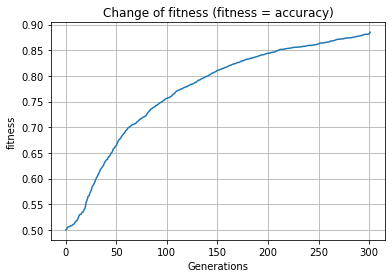

In [205]:
# Plotting increase of fitness in training
x = np.linspace(0, len(cels), len(cels))
fig, ax = plt.subplots(1, 1)
ax.plot(x, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy)")

plt.grid()
plt.show()


## 3. Validation

Here we use the weights of the most fit chromosome after the optimization using GA in our classifier.
We classify the whole test set and print the results both in terms of accuracy and CEL to see how it performs.

In [206]:
classifier.set_weights(ch.ws_1, ch.ws_2, ch.ws_3)
cel_post, output_post, acc_post = classifier.predict_whole_set(X_test, Y_test)

<ipython-input-177-bd99c7f08a9d>:77: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
<ipython-input-177-bd99c7f08a9d>:77: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
C:\Users\abdka\anaconda3\envs\testing\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [207]:
print("Accuracy before training: ", acc_pre)
print("Accuracy after training: ", acc_post)
print("CEL before training", cel_pre)
print("CEL after training", cel_post)

Accuracy before training:  0.4997333333333333
Accuracy after training:  0.7376
CEL before training 5.072011638796448
CEL after training inf


In [210]:
print(output_post)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [202]:
print(ch.ws_1, ch.ws_1, ch.ws_3)

[[ -2.2469065    3.21252532  -6.27164822 ...  -2.13896112  -5.59220524
   -0.0841441 ]
 [ -0.44141939   8.48862487   3.71262239 ...   0.7381675  -14.12409882
  -13.86798985]
 [  6.99323263 -14.80405034  -8.98340341 ...  -1.98339349  -0.34661764
   -8.79816289]
 ...
 [  1.41649973  -7.57797793   5.44557948 ...   3.50381265   1.60514616
    3.92438687]
 [ -5.87699909   0.77728401 -14.88713639 ...  -6.71890871   0.60682239
   -8.91303156]
 [-13.3781284   -5.36872497   6.83519258 ...   1.88020177  -1.68629528
  -18.15099109]] [[ -2.2469065    3.21252532  -6.27164822 ...  -2.13896112  -5.59220524
   -0.0841441 ]
 [ -0.44141939   8.48862487   3.71262239 ...   0.7381675  -14.12409882
  -13.86798985]
 [  6.99323263 -14.80405034  -8.98340341 ...  -1.98339349  -0.34661764
   -8.79816289]
 ...
 [  1.41649973  -7.57797793   5.44557948 ...   3.50381265   1.60514616
    3.92438687]
 [ -5.87699909   0.77728401 -14.88713639 ...  -6.71890871   0.60682239
   -8.91303156]
 [-13.3781284   -5.36872497   6.

#### PyTorch test

The assignment asks to build own classifier in Python without using libraries like PyTorch or Tensorflow. Thus I build my own classifier class as seen above.

But I wanted to compare training weights using GA vs using SDG. I didn't want to build SDG training algorithm without libraries since the assignment doesn't ask for building a SDG trainer. Thus to make the comparison I used PyTorch here.

Below is the "training with SDG" routine using PyTorch, and the results shown in a plot.

In [178]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

In [179]:
# Training function

def training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, vocab_length):
    results = list()
    accuracies = list()
    valid_results = list()
    valid_accuracies = list()

    #model.float()
    for ep in range(num_epochs):
        running_loss = 0
        valid_loss = 0
        total = 0
        correct = 0
        total_valid = 0
        correct_valid = 0
        model.train() # Set model into training mode
        for batch in train_loader:
            # We extract the images and labels from the batch
            vector = batch[:, :vocab_length]
            labels = batch[:, vocab_length]
            labels = torch.tensor(labels, dtype=torch.long)
            # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
            # all previos gradient descents, instead of the gradient descents on the current batch.
            optimizer.zero_grad() 
            output = model(vector) # prediction / output from the model

            loss = criterion(output, labels)  # We calculate the loss here
            loss.backward() # Computes the derivative of the loss using backpropagation.
            optimizer.step() # We update the weights

            running_loss += loss.item() # Sum the loss here
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        else:
            results.append(running_loss / len(train_loader))  # We append the mean loss into a list
            accuracies.append(correct / total)
    
        # Validation part
        model.eval()
        with torch.no_grad(): # This will prevent calculation of gradient descents
            for batch in valid_loader:
                vector = batch[:, :vocab_length]
                labels = batch[:, vocab_length]
                valid_output = model(vector) # Prediciton
                loss = criterion(valid_output, labels.long()) # Calculation of loss
                valid_loss += loss.item() # Sum the loss

                _, predicted = torch.max(valid_output.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
            else:
                valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
                valid_accuracies.append(correct_valid / total_valid)
    return results, accuracies, valid_results, valid_accuracies

In [180]:
# Setting the learning rate and epoch.
learning_rate = 0.00003

num_epochs = 15

criterion = nn.CrossEntropyLoss()



In [181]:
# Buildint torch values

train_torch = np.c_[X_train, Y_train]

train_torch = torch.from_numpy(train_torch)
train_torch = torch.tensor(train_torch, dtype=torch.float)

valid_torch = np.c_[X_valid, Y_valid]

valid_torch = torch.from_numpy(valid_torch)
valid_torch = torch.tensor(valid_torch, dtype=torch.float)

<ipython-input-181-b33fb47361d0>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_torch = torch.tensor(train_torch, dtype=torch.float)
<ipython-input-181-b33fb47361d0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_torch = torch.tensor(valid_torch, dtype=torch.float)


In [182]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_torch, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_torch, batch_size=1, shuffle=True)

In [183]:
# Building the model which is same as the model we'll use in GA
model = nn.Sequential(nn.Linear(len(vocab), 16),
                      nn.ReLU(),
                      nn.Linear(16, 8),
                      nn.ReLU(),
                      nn.Linear(8,2)
                     )

optimizer = optim.SGD(model.parameters(), lr = learning_rate)


        
        
    

In [ ]:
# Training with SDG using the model
sgd_results, accuracies, sgd_results_valid, accuracies_valid = training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, len(vocab))

<ipython-input-179-14579e24792d>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [185]:
len(sgd_results)

15

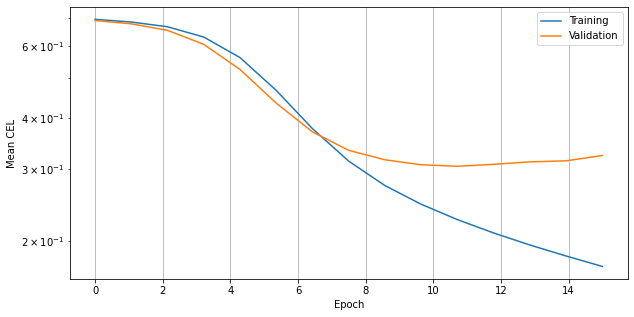

15

In [186]:
# Plotting the results
x_axis = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, sgd_results, label='Training')
ax.plot(x_axis, sgd_results_valid, label='Validation')
ax.set_ylabel("Mean CEL")
ax.set_xlabel("Epoch")
ax.grid()

ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend()

plt.show()
len(sgd_results)

In [187]:
print("Training mean CEL", sgd_results[-1])
print("Accuracy on training", accuracies[-1])
print("Validation mean CEL", sgd_results_valid[-1])
print("Accuracy on validation", accuracies_valid[-1])

0.6962735133307321
0.1728475492903295
0.5004285714285714
0.9410857142857143
0.6916133698701858
0.3230799564411482
0.5041333333333333
0.8730666666666667


35000

## 4. Conclusions

## Draft codes

In [103]:
arr1 = [1,2,3]
arr2 = [4,5]
arr3 = [7,8, 9,10]

nparr3 = np.array([arr1, arr2, arr3])
nparr = np.array([[1,2,3],[3,4,5],[4,5,6]])
nparr2 = np.array([[1, 3],[3, 4],[3,4],[3,2],[2,1],[9,3]])

np.argmax(nparr2, axis=1)
nparr2

<ipython-input-103-b4c45037dd8a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nparr3 = np.array([arr1, arr2, arr3])


array([[1, 3],
       [3, 4],
       [3, 4],
       [3, 2],
       [2, 1],
       [9, 3]])

In [125]:
string1 = "aa \x92 uu"

print(string1)

text = re.sub(r'[\\x]', '', string1)
print(text)

aa  uu
aa  uu
